In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

! mkdir ascii
! tar xzf drive/MyDrive/ocr/database/ascii.tgz -C ascii
! mkdir lines
! tar xzf drive/MyDrive/ocr/database/lines.tgz -C lines
! mkdir words
! tar xzf drive/MyDrive/ocr/database/words.tgz -C words
! cp drive/MyDrive/ocr/src/importation.py importation.py

Mounted at /content/drive


In [ ]:
#from importation import get_images_size, get_words
from importation import Importation

import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [ ]:
imp = Importation('')
# Words
words = imp.get_words()
words.head()

,word_id,result_w_seg,greylevel,x,y,w,h,grammatical_tag,label,file,form_id,writer_id,word_size
0,a01-000u-00-00,ok,154,408,768,27,51,AT,A,words/a01/a01-000u/a01-000u-00-00.png,a01-000u,000,1
1,a01-000u-00-01,ok,154,507,766,213,48,NN,MOVE,words/a01/a01-000u/a01-000u-00-01.png,a01-000u,000,4
2,a01-000u-00-02,ok,154,796,764,70,50,TO,to,words/a01/a01-000u/a01-000u-00-02.png,a01-000u,000,2
3,a01-000u-00-03,ok,154,919,757,166,78,VB,stop,words/a01/a01-000u/a01-000u-00-03.png,a01-000u,000,4
4,a01-000u-00-04,ok,154,1185,754,126,61,NPT,Mr.,words/a01/a01-000u/a01-000u-00-04.png,a01-000u,000,3


In [ ]:
# ajouter variables heigth et width 
img_size = imp.get_images_size(words["file"])
words["width"] = img_size.apply(lambda x : x[0])
words["height"] = img_size.apply(lambda x : x[1])

In [ ]:
# selectionner les mots de 11 caractères maximum
n_lettres_max=11
df = words[words.word_size<=n_lettres_max][['file', 'word_size', 'width', 'height', 'label']]
print("Nombre d'enregistrements ", df.shape[0])

print("Répartition des mots par nombre de lettres :")
df.groupby('word_size').count()


Nombre d'enregistrements  95285
Répartition des mots par nombre de lettres :


,file,width,height,label
word_size,,,,
1,14172,14172,14172,14172
2,14800,14800,14800,14800
3,18659,18659,18659,18659
4,13869,13869,13869,13869
5,9546,9546,9546,9546
6,7008,7008,7008,7008
7,6312,6312,6312,6312
8,4425,4425,4425,4425
9,3256,3256,3256,3256


In [ ]:
df.head()

,file,word_size,width,height,label
0,words/a01/a01-000u/a01-000u-00-00.png,1,27,51,A
1,words/a01/a01-000u/a01-000u-00-01.png,4,213,48,MOVE
2,words/a01/a01-000u/a01-000u-00-02.png,2,70,50,to
3,words/a01/a01-000u/a01-000u-00-03.png,4,166,78,stop
4,words/a01/a01-000u/a01-000u-00-04.png,3,126,61,Mr.


In [ ]:
#Taille moyenne des images:
mean_width = int(df["width"].mean())
mean_height = int(df["height"].mean())
print(f"\nlargeur moyenne : {mean_width}")
print(f"hauteur moyenne : {mean_height}")




largeur moyenne : 152
hauteur moyenne : 69


In [ ]:
# importer les images
dim = (mean_width, mean_height)


X = []



for file, label in zip(df['file'], df['label']) :
  image = cv2.resize(cv2.imread(file, cv2.IMREAD_GRAYSCALE),
                  dim, cv2.IMREAD_GRAYSCALE)
  X.append(np.array(image))


In [ ]:
Y = df['word_size']

In [ ]:

# reshape X
# Normalise input data to range [0,1]
X = np.array(X)



In [ ]:
X.shape

(95285, 69, 152)

In [ ]:
X = X.astype('float32')

In [ ]:
X = X.reshape([-1, 69*152])
X /= 255.0

In [ ]:
# Dataset d'entrainement et de test
encoder = LabelEncoder()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [ ]:
# Random Forest
rf_clf = RandomForestClassifier(n_estimators = 90, criterion = 'gini', max_depth = 5, n_jobs = -1)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=90, n_jobs=-1)

In [ ]:
# prediction
test_pred = rf_clf.predict(X_test)

print(accuracy_score(y_test, test_pred))
print(classification_report(y_test, test_pred))
cnf_matrix = confusion_matrix(y_test, test_pred)

0.3916127948954748
              precision    recall  f1-score   support

           1       0.90      0.89      0.90      3525
           2       0.56      0.38      0.46      3740
           3       0.30      0.83      0.44      4608
           4       0.16      0.14      0.15      3454
           5       0.12      0.00      0.00      2393
           6       0.69      0.00      0.01      1803
           7       0.21      0.25      0.22      1570
           8       0.00      0.00      0.00      1121
           9       0.00      0.00      0.00       804
          10       0.00      0.00      0.00       531
          11       0.00      0.00      0.00       273

    accuracy                           0.39     23822
   macro avg       0.27      0.23      0.20     23822
weighted avg       0.38      0.39      0.33     23822



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# modèle sans limites pour la prodfondeurs des arbres
rf_clf2 = RandomForestClassifier(n_estimators = 100, criterion = 'gini', n_jobs = -1)
rf_clf2.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

In [ ]:
test_pred2 = rf_clf2.predict(X_test)

print(accuracy_score(y_test, test_pred2))
print(classification_report(y_test, test_pred2))
cnf_matrix = confusion_matrix(y_test, test_pred2)

0.5362270170430694
              precision    recall  f1-score   support

           1       0.96      0.96      0.96      3525
           2       0.76      0.80      0.78      3740
           3       0.49      0.80      0.61      4608
           4       0.34      0.43      0.38      3454
           5       0.27      0.19      0.22      2393
           6       0.26      0.12      0.17      1803
           7       0.28      0.23      0.25      1570
           8       0.26      0.12      0.16      1121
           9       0.25      0.06      0.10       804
          10       0.28      0.01      0.03       531
          11       0.33      0.00      0.01       273

    accuracy                           0.54     23822
   macro avg       0.41      0.34      0.33     23822
weighted avg       0.50      0.54      0.50     23822



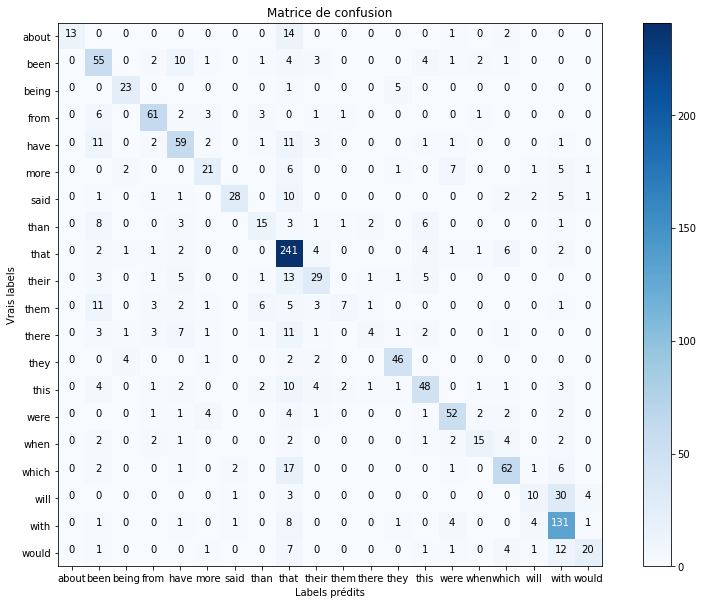

Le mot 'about' a souvent été pris pour le mot 'that'
Le mot 'been' a souvent été pris pour le mot 'have'
Le mot 'from' a souvent été pris pour le mot 'been'
Le mot 'have' a souvent été pris pour le mot 'been'
Le mot 'have' a souvent été pris pour le mot 'that'
Le mot 'more' a souvent été pris pour le mot 'that'
Le mot 'more' a souvent été pris pour le mot 'were'
Le mot 'said' a souvent été pris pour le mot 'that'
Le mot 'than' a souvent été pris pour le mot 'been'
Le mot 'than' a souvent été pris pour le mot 'this'
Le mot 'that' a souvent été pris pour le mot 'which'
Le mot 'their' a souvent été pris pour le mot 'that'
Le mot 'them' a souvent été pris pour le mot 'been'
Le mot 'them' a souvent été pris pour le mot 'than'
Le mot 'there' a souvent été pris pour le mot 'have'
Le mot 'there' a souvent été pris pour le mot 'that'
Le mot 'this' a souvent été pris pour le mot 'that'
Le mot 'which' a souvent été pris pour le mot 'that'
Le mot 'which' a souvent été pris pour le mot 'with'
Le mo

In [ ]:
num_classes = 20
plt.figure(figsize=(15,10))

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(num_classes)
classes = encoder.inverse_transform(tick_marks)
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    if(cnf_matrix[i,j] >5 and i!=j):
        print("Le mot '{0}' a souvent été pris pour le mot '{1}'".format(classes[i],classes[j]))